# NoteFlow
- The first code cell of a noteflow is special and documents inputs and outputs via formatted comments.
- However, it is arbitrary code and can be used in any way you like for local development and testing. In production, values provided by the user are inserted just below this cell. 
- The formatted comments (I/O spec) have three parts:
    - **input/ouput**: marks variable as an input or output
    - **type**: I/O is typed (for the underlying API). Types are: `string`, `number`, `boolean`, `filepath`, and `dirpath`
    - **description**: The rest of the comment becomes the prompt/description for the field in the generated App. 

In [1]:
include_range = True           #input  boolean   Include Best and Worst States
states = 'Washington'          #input  string    Additional States to include (e.g. Washington, New York State)
min_date = None                #input  string    Start Date (default: all dates)

asof_date = None               #output string    Data as-of date
us_total = None                #output number    Total People Fully Vaccinated in US
plot_image = 'vaccinated.png'  #output filepath  Plot Image

## NoteFlow Libraries
- `numpy`, `pandas`, `matplotlib` and many others are pre-installed
- install missing libraries with `!pip install` 

In [2]:
import pandas as pd

## Covid Data
- [Data](https://github.com/owid/covid-19-data) on COVID-19 (coronavirus) by [Our World in Data](https://github.com/owid)

> State-by-state data on United States COVID-19 vaccinations. We rely on the data updated daily by the United States Centers for Disease Control and Prevention.

 

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv')
df.head(2)

,date,location,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
0,2021-01-12,Alabama,78134.0,377025.0,70861.0,0.15,1.59,7270.0,1.45,7.69,NaN,NaN,NaN,0.207
1,2021-01-13,Alabama,84040.0,378975.0,74792.0,0.19,1.71,9245.0,1.53,7.73,5906.0,5906.0,1205.0,0.222


### Transform Dates

In [4]:
df['date'] = pd.to_datetime(df['date'])

asof_date = str(df['date'].max())
print('asof_date:', asof_date)

min_date = pd.to_datetime(min_date, errors='coerce')
min_date = df['date'].min() if pd.isnull(min_date) else min_date

date_range = min_date, asof_date
print('date_range:', date_range)

asof_date: 2021-05-07 00:00:00
date_range: (Timestamp('2020-12-20 00:00:00'), '2021-05-07 00:00:00')


### US Data

In [5]:
state_list = set(['United States']) # Always show US

In [6]:
us_total = df['people_fully_vaccinated'][(df['location']=='United States') & (df['date'] == asof_date)]
assert len(us_total) == 1, 'Error: Repeated Dates'

us_total = us_total.values[0]
print(us_total)

110874920.0


### State Data

In [7]:
# we want to pick best/worst exlcuding territories and other locations
fifty_states = set(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 
                    'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 
                    'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 
                    'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 
                    'New Mexico', 'New York State', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
                    'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah',
                    'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'])
len(fifty_states)

50

In [8]:
max_vax = df[df['location'].isin(fifty_states)].groupby('location')['people_fully_vaccinated_per_hundred'].max().sort_values()

worst_state = max_vax.index[0]
print('Worst:', worst_state, '@', max_vax[worst_state])
if include_range: 
    state_list.add(worst_state)

best_state = max_vax.index[-1]
print('Best:', best_state, '@', max_vax[best_state])
if include_range: 
    state_list.add(best_state)

Worst: Mississippi @ 24.92
Best: Maine @ 43.67


In [9]:
# Were additional states provided? (Ignore case)
location = df['location'].str.strip().str.lower() # valid locations

for state in states.split(','):
    state = state.lower().strip()
    if (location == state).any():
        state = df['location'][location == state].values[0]
        print('Selected:', state, '@', df['people_fully_vaccinated_per_hundred'][df['location']==state].max())
        state_list.add(state)
    else:
        print('Warning: Skipped "{}" because not a valid location in the CDC data.'.format(state))

Selected: Washington @ 35.1


### Plot

In [10]:
sel_df = df[df['location'].isin(state_list)].pivot(index='date', columns='location', values='people_fully_vaccinated_per_hundred')

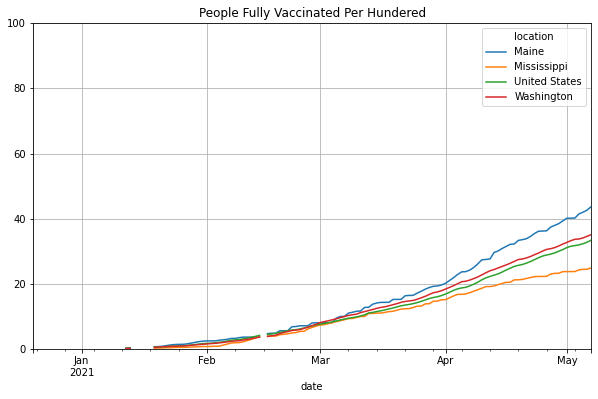

In [11]:
fig = sel_df.plot(title='People Fully Vaccinated Per Hundered', xlim=date_range, ylim=(0,100), grid=True, figsize=(10, 6)).get_figure()

In [12]:
fig.savefig(plot_image)